# First Data Exploration

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import zipfile
from unidecode import unidecode
import matplotlib.ticker as mtick

import nltk
from nltk.corpus import stopwords
import string
import re

In [3]:
COLLECTIONS_PATH = "collections/"
SMALL_NA_SAMPLE = False

## building the corpus

In [4]:
if SMALL_NA_SAMPLE:
    na_dict = {"Belga": "Belga"}
else:
    na_dict = {"AFP1": "AFP", 
           "AFP2": "AFP", 
           "ANP": "ANP", 
           "ANSA": "ANSA", 
           "AP1": "AP", 
           "AP2": "AP", 
           "APA": "APA", 
           "Associated_Press": "AP", 
           "ATS1": "ATS",
           "ATS2": "ATS",
           "ATS3": "ATS",
           "Belga": "Belga", 
           "BTA": "BTA", 
           "CTK": "CTK", 
           "DDP-DAPD": "DDP-DAPD", 
           "DNB": "DNB",
           "Domei": "Domei", 
           "DPA": "DPA", 
           "Europapress": "Europapress", 
           "Extel": "Extel", 
           "Havas": "Havas",
           "Havasagentur": "Havas",
           "Interfax": "Interfax",
           "PAP": "PAP",
           "Reuter": "Reuters",
           "Reuters": "Reuters",
           "reutersche": "Reuters",
           "SPK": "SPK",
           "Stefani": "Stefani",
           "Tanjug": "Tanjug",
           "TASS": "TASS",
           "Telunion": "Telunion",
           "TT-Sweden": "TT",
           "UPI": "UP-UPI",
           "Wolff": "Wolff"
          
          }


#na_dict = {"Belga":"Belga"}

#specify columns to import: all columns but "type" (empty) and last one (only title, indicating size of the collection)
cols = ['uid', 'language', 'title', 'size', 'country', 'newspaper',
       'issue', 'pages', 'nb_pages', 'relevance', 'year', 'is_on_front',
       'date', 'persons_mentioned', 'locations_mentioned', 'content',
       'access_right', 'content_provider', 'is_content_available',
       'collections']

#specify types for each column
dtypes = {'uid': str, 'language': str, 'title': str, 'size': int, 'country': str, 'newspaper': str,
       'issue': str, 'pages': str, 'nb_pages': int, 'relevance': float, 'year': int, 'is_on_front': bool,
       'date': object, 'persons_mentioned': str, 'locations_mentioned': str, 'content': str,
       'access_right': str, 'content_provider': str, 'is_content_available': str,
       'collections': str}

### importing all collections

In [5]:
#build full collection in one dataframe
df_all = pd.DataFrame()

for na_collection, na_name in na_dict.items():
    #import next news agency content
    path = COLLECTIONS_PATH + na_collection + ".zip"
    temp = pd.read_csv(path, compression="zip", sep=";", usecols=cols, dtype=dtypes)
    #save name of news agency
    temp["newsagency"] = na_name
    #add to rest
    df_all = pd.concat([df_all,temp])    

In [ ]:
print(f"number of articles imported until now: {len(df_all)}")

number of articles imported until now: 3503618


### Disambiguation of "Mixed" collection

In [ ]:
mixed_nas = {"afpreuters": ["AFP", "Reuters"], 
             "afpreuter": ["AFP", "Reuters"], 
             "atsafp": ["ATS", "AFP"], 
             "atsreuters": ["ATS", "Reuters"], 
             "atsreuter": ["ATS", "Reuters"], 
             "atsjafp": ["ATS", "AFP"], 
             "atsap": ["ATS", "AP"], 
             "aplddp": ["AP", "DDP-DAPD"], 
             "aplafp": ["AP", "AFP"],
             "afplap": ["AFP", "AP"], 
             "dpalafp": ["DPA", "AFP"], 
             "atsjreuter": ["ATS", "Reuters"], 
             "atsfafp": ["ATS", "AFP"], 
             "ddplap": ["DDP-DAPD", "AP"], 
             "aplsda": ["AP", "ATS"], 
             "aplddp": ["AP", "DDP-DAPD"], 
             "sdalafp": ["ATS", "AFP"], 
             "atsjred": ["ATS"], 
             "atsred": ["ATS"]}

In [ ]:
len_before = len(df_all)

#import Mixed.zip file
path = COLLECTIONS_PATH + "Mixed.zip"
mixed = pd.read_csv(path, compression="zip", sep=";", usecols=cols)
mixed = mixed[mixed["content"].notna()]

#normalize content column in a copy of Mixed
mixed_no_acc = mixed.copy()
mixed_no_acc["content"] = mixed_no_acc["content"].apply(lambda x: unidecode(x))

count = 0
for mixed_word, mixed_na_list in mixed_nas.items():
    #get all entries with the mixed_word in it
    temp = mixed[mixed_no_acc["content"].str.contains(mixed_word, case=False, na=False)]
    
    #first store mixed_na_list in a new column, then create one row per na entry (via explode)
    temp =  temp.assign(newsagency = [mixed_na_list] * len(temp))
    temp = temp.explode("newsagency", ignore_index=True)
    count += len(temp)
    
    #concatenate to existing df_all
    df_all = pd.concat([df_all,temp])

#delete duplicates
df_all.drop_duplicates(inplace=True)

print(f"#articles in Mixed.zip: {len(mixed)}, #rows stored (with duplicates): {count},\n\
final #rows stored (without duplicates): {len(df_all)-len_before}")

#articles in Mixed.zip: 5941, #rows stored (with duplicates): 14854,
final #rows stored (without duplicates): 5035


## add useful columns

In [ ]:
#Pauline
def get_decade(year):
    return int((year//10)*10)

#add decade column
df_all["decade"] = df_all["year"].apply(lambda x: int(get_decade(x)))

## missing values

In [ ]:
df_all.isnull().sum()

uid                          0
language                     0
title                   314699
size                         0
country                     64
newspaper                    0
issue                        0
pages                        0
nb_pages                     0
relevance                    0
year                         0
is_on_front                  0
date                         0
persons_mentioned       893904
locations_mentioned     352491
content                 174710
access_right                 0
content_provider             0
is_content_available    173216
collections                  0
newsagency                   0
decade                       0
dtype: int64

In [ ]:
no_content = df_all[df_all["content"].isnull()]
print(f"#articles without content: {len(no_content)}, percentage: {len(no_content)/len(df_all)}")
no_content.head()

#articles without content: 174710, percentage: 0.04979403776891018


,uid,language,title,size,country,newspaper,issue,pages,nb_pages,relevance,...,date,persons_mentioned,locations_mentioned,content,access_right,content_provider,is_content_available,collections,newsagency,decade
111034,IMP-1955-04-01-a-i0061,en,Le « blocus » de Berlin,1,CH,IMP,IMP-1955-04-01-a,5,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111035,IMP-1955-04-01-a-i0067,en,Une protestation des Occidentaux,1,CH,IMP,IMP-1955-04-01-a,5,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111036,IMP-1955-04-01-a-i0068,en,Eisenhower ne s'est pas prononcé sur la défens...,1,CH,IMP,IMP-1955-04-01-a,5,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111037,IMP-1955-04-01-a-i0089,en,Trois dames carbonisées,1,CH,IMP,IMP-1955-04-01-a,7,1,0.0,...,1955-04-01T00:00:00Z,NaN,NaN,NaN,OpenPrivate,SNL,y,"local-ps-RlHa2EhD,local-IIV_6APb-4hURA0iX",AFP,1950
111038,IMP-1955-04-01-a-i0344,en,Les préparatifs se poursuivent pour une confér...,1,CH,IMP,IMP-1955-04-01-a,26,1,0.0,...,1955-04-01T00:00:00Z,NaN,Allemagne|PARIS,NaN,OpenPrivate,SNL,y,"local-IIV_6APb-IaAgqTUh,local-IIV_6APb-X0x8Swx...",AFP,1950


In [ ]:
df_all = df_all[df_all["content"].notna()]
print("After deleting articles without content:")
df_all.isnull().sum()

After deleting articles without content:


uid                          0
language                     0
title                   312651
size                         0
country                     64
newspaper                    0
issue                        0
pages                        0
nb_pages                     0
relevance                    0
year                         0
is_on_front                  0
date                         0
persons_mentioned       817899
locations_mentioned     325228
content                      0
access_right                 0
content_provider             0
is_content_available         0
collections                  0
newsagency                   0
decade                       0
dtype: int64

### Missing value statistics

In [ ]:
def percentage_barplot(df_content, df_no_content, groupby_col, figsize=None):
    df = df_content[[groupby_col, "uid"]].groupby(groupby_col).count().rename(columns={"uid":"has_content"})
    #join with no_content dataframe which is also grouped by newsagencies
    df = df.join(df_no_content[[groupby_col, "uid"]].groupby(groupby_col).count().rename(columns={"uid":"no_content"}),
                 how="outer")
    df = df.fillna(0)

    #column: percentage of entries without content    
    df["perc_no_content"] = df.apply(lambda x: x.no_content/(x.has_content + x.no_content), axis=1)
    ax = df["perc_no_content"].plot.bar(figsize=figsize, title="% of missing content per "+groupby_col,
                                        ylabel="% of articles with missing content")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    return df

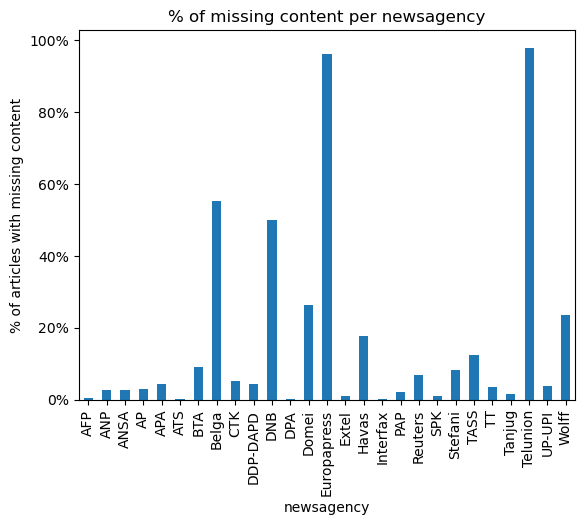

In [ ]:
Newsagencies = percentage_barplot(df_all, no_content, "newsagency")

In [ ]:
Newsagencies

,has_content,no_content,perc_no_content
newsagency,,,
AFP,664174,2272,0.003409
ANP,4878,139,0.027706
ANSA,9624,258,0.026108
AP,506556,15649,0.029967
APA,8426,373,0.042391
ATS,1033750,2692,0.002597
BTA,1963,193,0.089518
Belga,4900,6054,0.552675
CTK,4397,238,0.051348


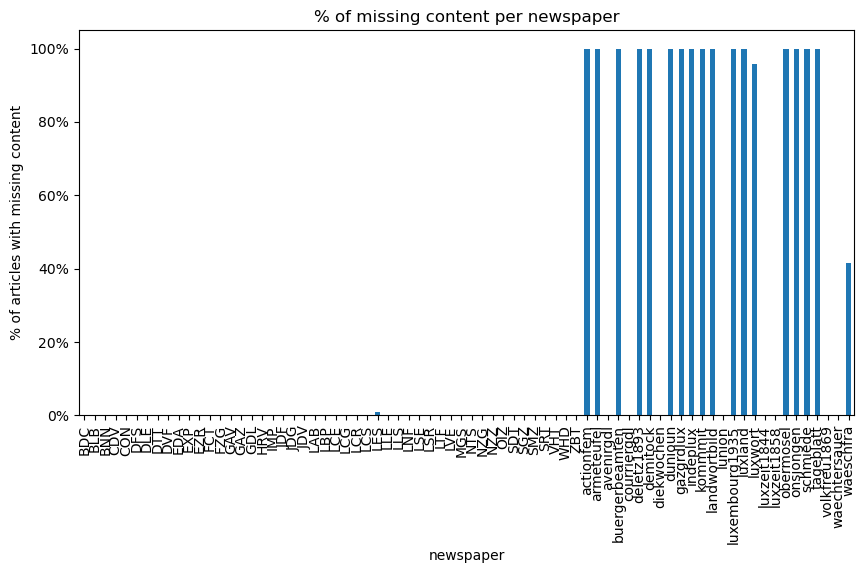

In [ ]:
_ = percentage_barplot(df_all, no_content, "newspaper", figsize=(10,5))

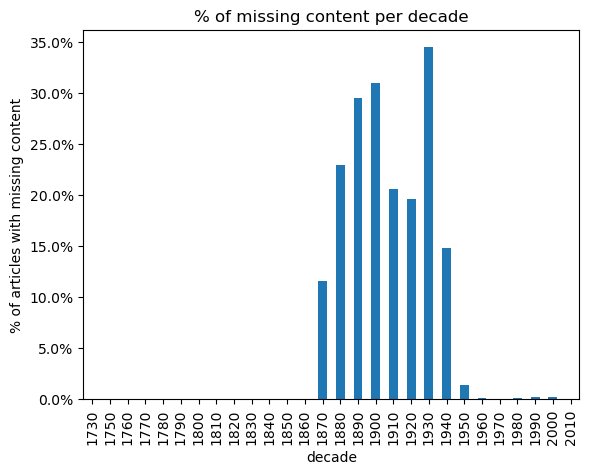

In [ ]:
_ = percentage_barplot(df_all, no_content, "decade")

### Check for downloading error

In [ ]:
#check if high number are due to error during download
Europapress = pd.read_csv(COLLECTIONS_PATH+"Europapress.zip", compression="zip", sep=";", usecols=cols, dtype=dtypes)
Europapress0 = pd.read_csv(COLLECTIONS_PATH+"Europapress-0.zip", compression="zip", sep=";", usecols=cols, dtype=dtypes)

print(f"Europapress #articles without content: {Europapress['content'].isna().sum()} of {len(Europapress)}\n\
Europapress0 #articles without content: {Europapress0['content'].isna().sum()} of {len(Europapress0)}")
#> not a download error

Europapress #articles without content: 7624 of 7929
Europapress0 #articles without content: 7624 of 7929


## Distributions per Newsagency

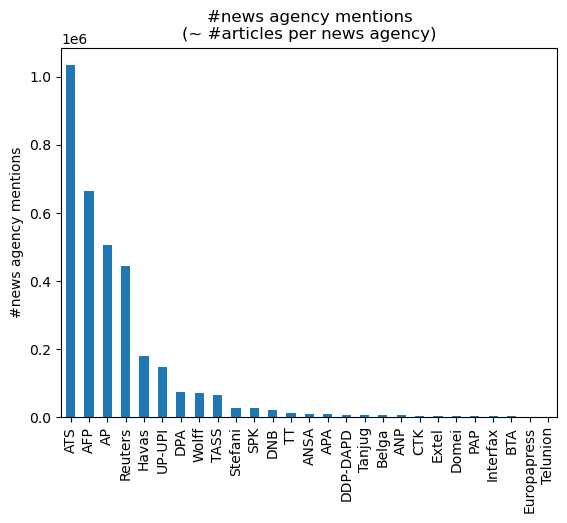

In [ ]:
df_all["newsagency"].value_counts().plot(kind='bar', title="#news agency mentions\n(~ #articles per news agency)", ylabel="#news agency mentions")
plt.show()

In [ ]:
Newsagencies["has_content"].sort_values()

newsagency
Telunion            89
Europapress        305
BTA               1963
Interfax          2762
PAP               2963
Domei             3507
Extel             4137
CTK               4397
ANP               4878
Belga             4900
Tanjug            5275
DDP-DAPD          6549
APA               8426
ANSA              9624
TT               12146
DNB              22064
SPK              25448
Stefani          26746
TASS             65706
Wolff            71373
DPA              75035
UP-UPI          147739
Havas           178719
Reuters         444712
AP              506556
AFP             664174
ATS            1033750
Name: has_content, dtype: int64

### Distributions over time

In [ ]:
#Pauline's code

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def get_c_per_year(year, colors = colors, sep = 10):
    # change color every sep years to visualize better
    return colors[(year // sep)%len(colors)]

def img_bar_plot(df, ax, xticks, title, log_scale = False, colors_sep=10, overlay_df = None):
    '''Display the yearly counts in df using a bar plot.
    
    df (DataFrame): data to be displayed, should include a col named 'year' and another called 'count'
    ax : figure axis to use for plotting, allows to construct subplots if needed
    xticks (iterator or list): range for ticks along x axis
    log_scale (bool): if True the counts will be displayed with a logarithmic scale for the y-axis
    colors_sep (int): number of years between color changes
    overlay_df (DataFrame): if not None, will display overlay_df's counts with reduced opacity.
    '''
    # get the colors for each years 
    colors = [get_c_per_year(y, sep=colors_sep) for  y in df['year']]
    
    # plot the counts
    ax.bar(df['year'], df['count'], color=colors)
    if(overlay_df is not None):
        # if overlay_df, add second set of counts
        ax.bar(df['year'], overlay_df['count'], color=colors, alpha=0.2)
    ax.set_xticks(xticks)
    if(log_scale):
        ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')

In [ ]:
na_per_year = pd.pivot_table(df_all, index="year", columns="newsagency", values="uid", aggfunc="count")
na_per_year.fillna(0, inplace=True)
na_per_year["count"] = na_per_year.sum(axis=1)
na_per_year1820 = na_per_year.reset_index()[["year", "count"]]
na_per_year1820 = na_per_year1820[na_per_year1820["year"]>=1820]

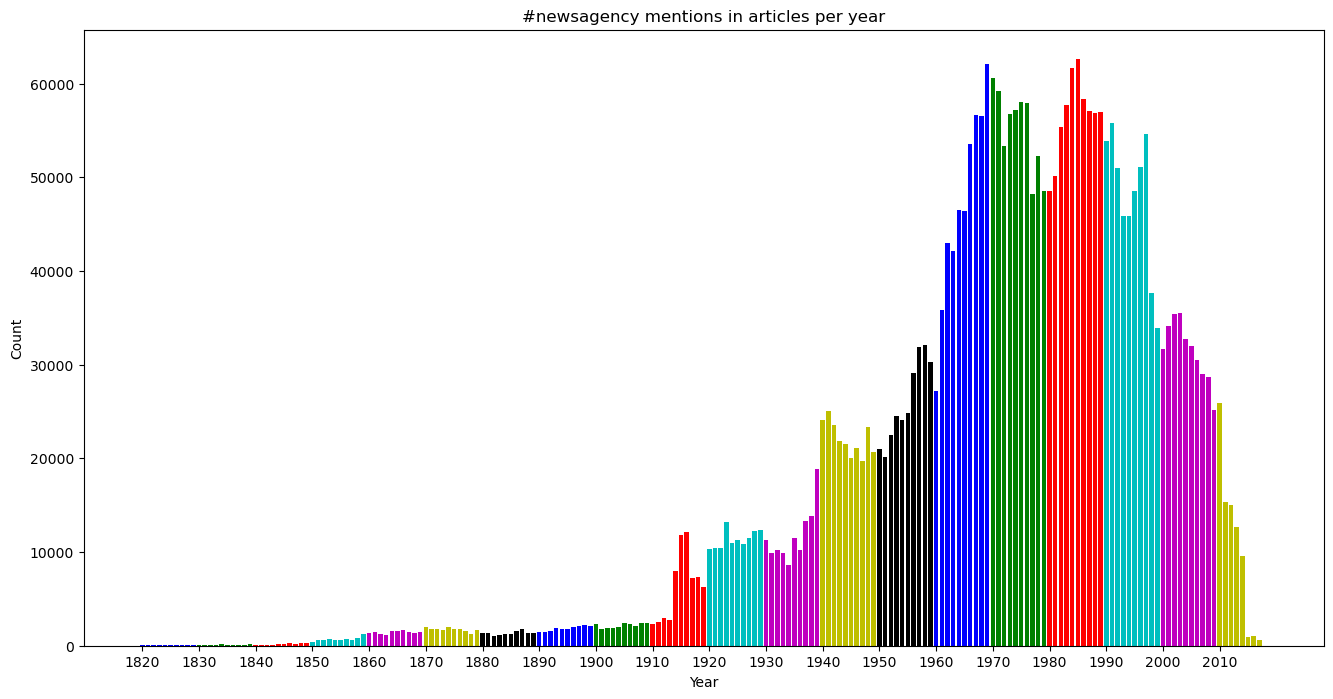

In [ ]:
f, ax = plt.subplots(1, figsize=(16,8))
img_bar_plot(na_per_year1820, ax, range(1820, 2019, 10), title="#newsagency mentions in articles per year")

In [ ]:
na_per_decade = pd.pivot_table(df_all, index="decade", columns="newsagency", values="uid", aggfunc="count")

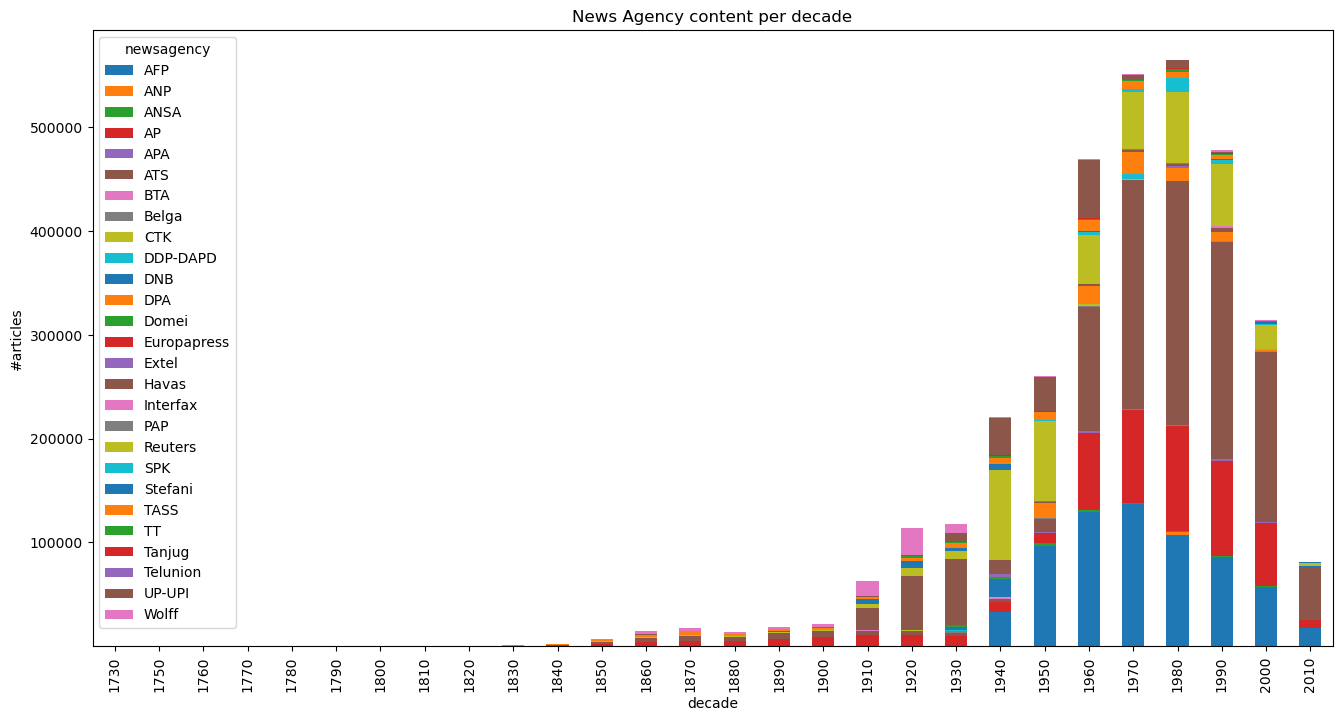

In [ ]:
na_per_decade.plot.bar(stacked=True, figsize=(16,8), ylabel="#articles", title="News Agency content per decade")
plt.show()

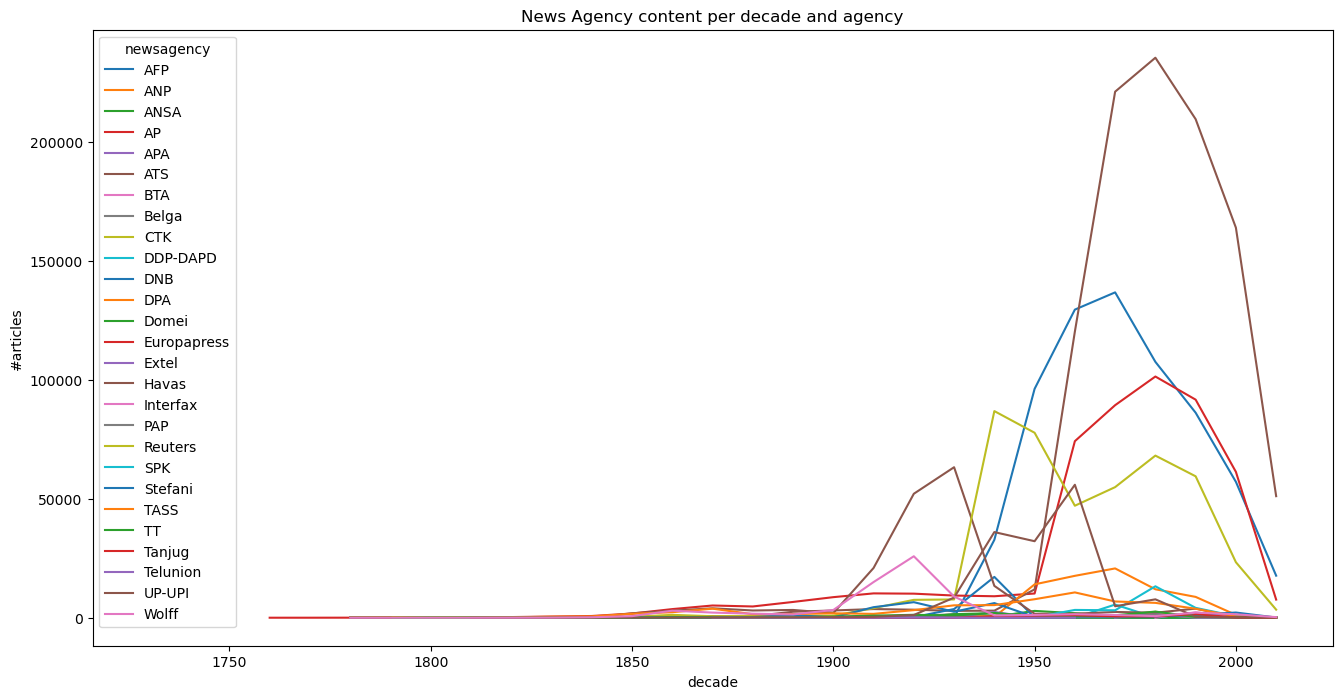

In [ ]:
na_per_decade.plot.line(figsize=(16,8), ylabel="#articles", title="News Agency content per decade and agency")
plt.show()

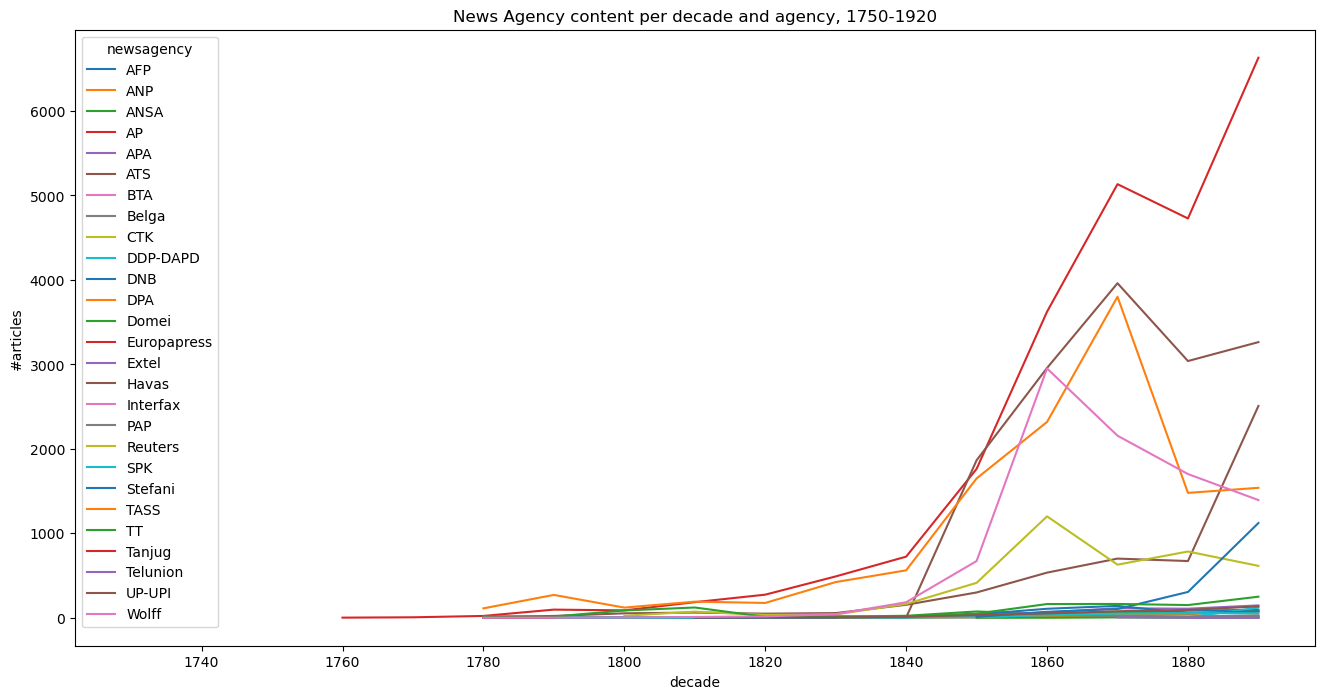

In [ ]:
na_per_decade.iloc[:16].plot.line(figsize=(16,8), ylabel="#articles",
                                   title="News Agency content per decade and agency, 1750-1920")
plt.show()

## Several Newsagency mentions per article

In [ ]:
#group by article, using all columns but the newsagency 
#       (as all the others should contain same column contents for the same article)
groupby_cols = cols.copy()
groupby_cols.append("decade")
df_unique = df_all.groupby(groupby_cols, dropna=False)["newsagency"].apply(list).reset_index()

# create one column with list of news agencies, one with string where NA's are seperated by commata
df_unique.rename({"newsagency":"newsagency_list"}, axis=1, inplace=True)
df_unique["newsagencies"] = df_unique["newsagency_list"].apply(lambda x: ", ".join(x))

#statistics
print(f"unique: {len(df_unique)}, percentage of articles only contained in one collection: \
{round(len(df_unique)/len(df_all)*100)}%")

unique: 2655447, percentage of articles only contained in one collection: 80%


In [ ]:
print("number of newagency mentions:" , len(df_all))

number of newagency mentions: 3333943


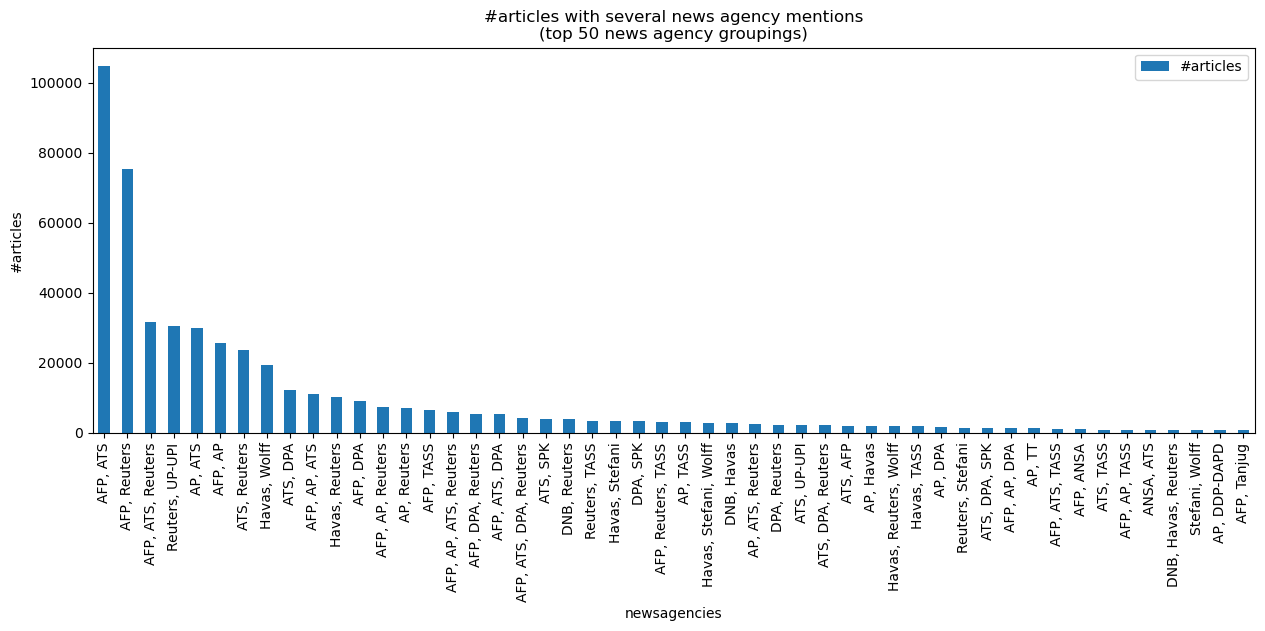

In [ ]:
na_mixed = df_unique[df_unique["newsagency_list"].str.len() > 1]
na_mixed_grouped = na_mixed[["uid", "newsagencies"]].groupby("newsagencies").count().rename({"uid":"#articles"}, axis=1)
na_mixed_grouped.nlargest(50, "#articles").plot(kind="bar", ylabel="#articles", title="#articles with several news agency mentions\n(top 50 news agency groupings)", figsize=(15,5))
plt.show()

In [ ]:
na_mixed_grouped.nlargest(10, "#articles")

,#articles
newsagencies,
"AFP, ATS",104815
"AFP, Reuters",75474
"AFP, ATS, Reuters",31575
"Reuters, UP-UPI",30531
"AP, ATS",29838
"AFP, AP",25537
"ATS, Reuters",23723
"Havas, Wolff",19318
"ATS, DPA",12296


### Distributions: articles per year

In [ ]:
na_unique_per_year = pd.pivot_table(df_unique, index="year", columns="newsagencies", values="uid", aggfunc="count")
na_unique_per_year.fillna(0, inplace=True)
na_unique_per_year["count"] = na_unique_per_year.sum(axis=1)
na_unique_per_year1820 = na_unique_per_year.reset_index()[["year", "count"]]
na_unique_per_year1820 = na_unique_per_year1820[na_unique_per_year1820["year"]>=1820]

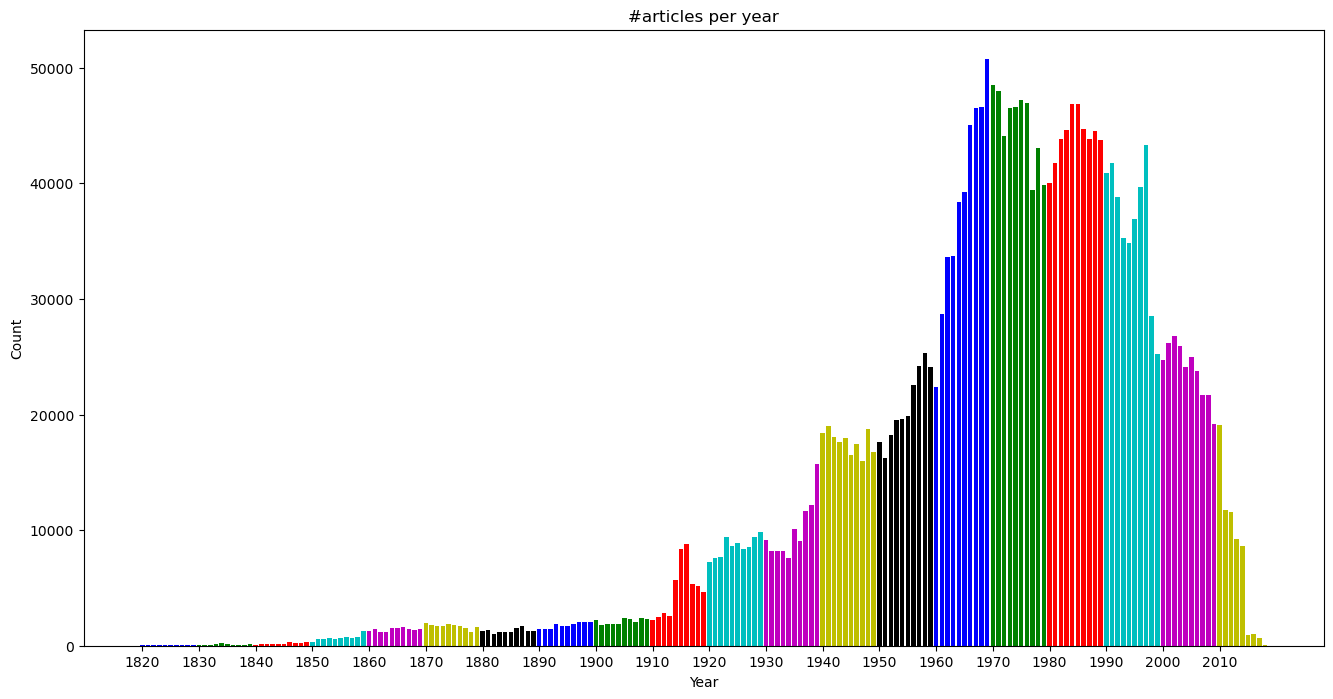

In [ ]:
f, ax = plt.subplots(1, figsize=(16,8))
img_bar_plot(na_unique_per_year1820, ax, range(1820, 2019, 10), title="#articles per year")

## Distributions per Newspaper

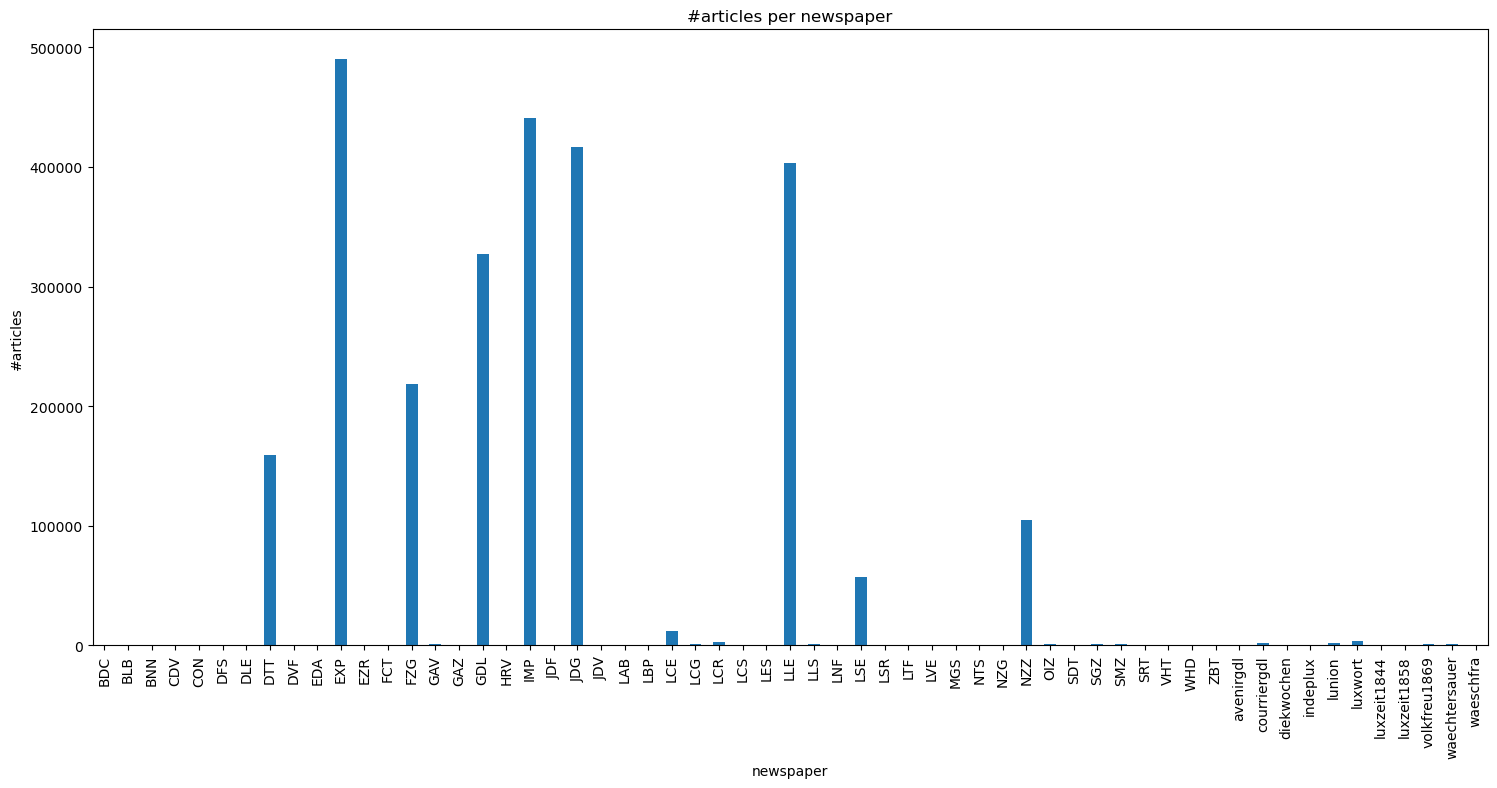

In [ ]:
articles_per_newspaper = pd.pivot_table(df_unique, index="newspaper", columns="newsagencies", values="uid", aggfunc="count")
articles_per_newspaper["all"] = articles_per_newspaper.sum(axis=1)
articles_per_newspaper["all"].plot.bar(title="#articles per newspaper", ylabel="#articles", figsize=(18, 8))
plt.show()

In [ ]:
na_per_newspaper = pd.pivot_table(df_all, index="newspaper", columns="newsagency", values="uid", aggfunc="count")
na_per_newspaper["all"] = na_per_newspaper.sum(axis=1)
#na_per_newspaper

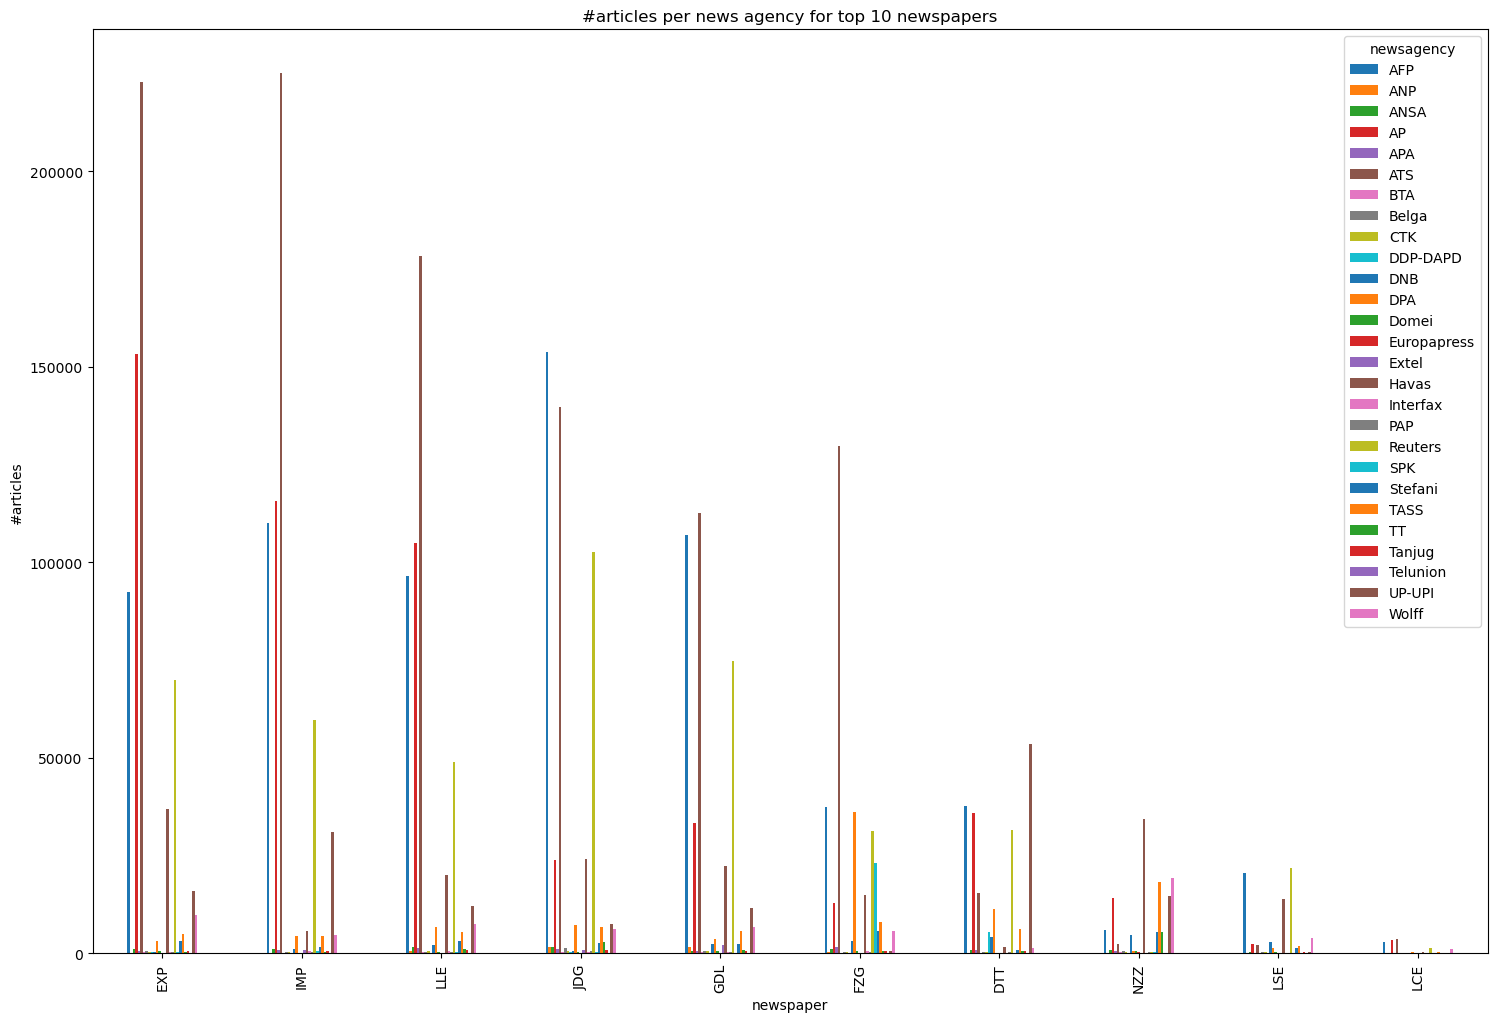

In [ ]:
na_per_newspaper10 = na_per_newspaper.nlargest(10, "all")
na_per_newspaper10.drop("all", axis=1, inplace=True)
na_per_newspaper10.plot.bar(title="#articles per news agency for top 10 newspapers", ylabel="#articles", figsize=(18, 12))
plt.show()

## Country statistics

In [ ]:
df_unique["country"].value_counts()

CH    2644101
LU      11283
Name: country, dtype: int64

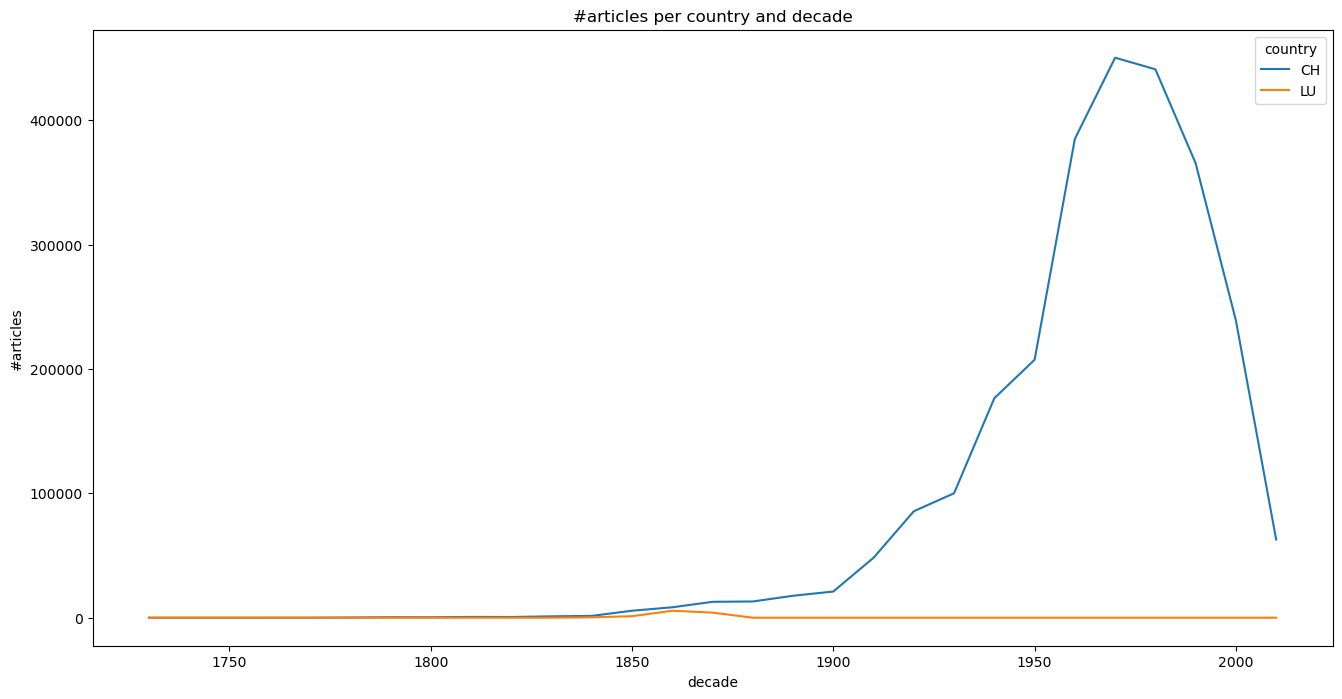

In [ ]:
articles_per_country = pd.pivot_table(df_unique, index="decade", columns="country", values="uid", aggfunc="count")
articles_per_country.fillna(0, inplace=True)
articles_per_country.plot.line(figsize=(16,8), ylabel="#articles", title="#articles per country and decade")
plt.show()

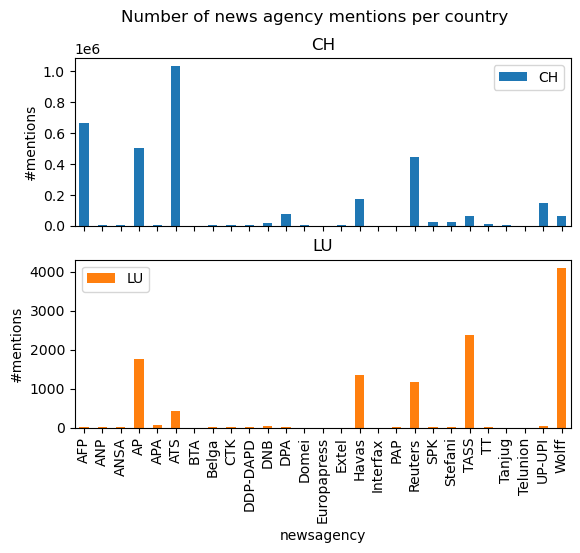

In [ ]:
na_per_country = pd.pivot_table(df_all, index="newsagency", columns="country", values="uid", aggfunc="count")
na_per_country.plot(kind="bar", subplots=True, title="Number of news agency mentions per country", ylabel="#mentions")
plt.show()

## Articles on Frontpage

In [ ]:
print(f"percentage of articles on the front page: {round(df_unique['is_on_front'].sum()/len(df_all)*100)}%")

percentage of articles on the front page: 7%


# NLP Statistics

In [ ]:
print(f"#articles per language:\n{df_unique['language'].value_counts()}")

#articles per language:
fr    2159589
de     495835
lb         23
Name: language, dtype: int64


## Distributions
### Number of words per article

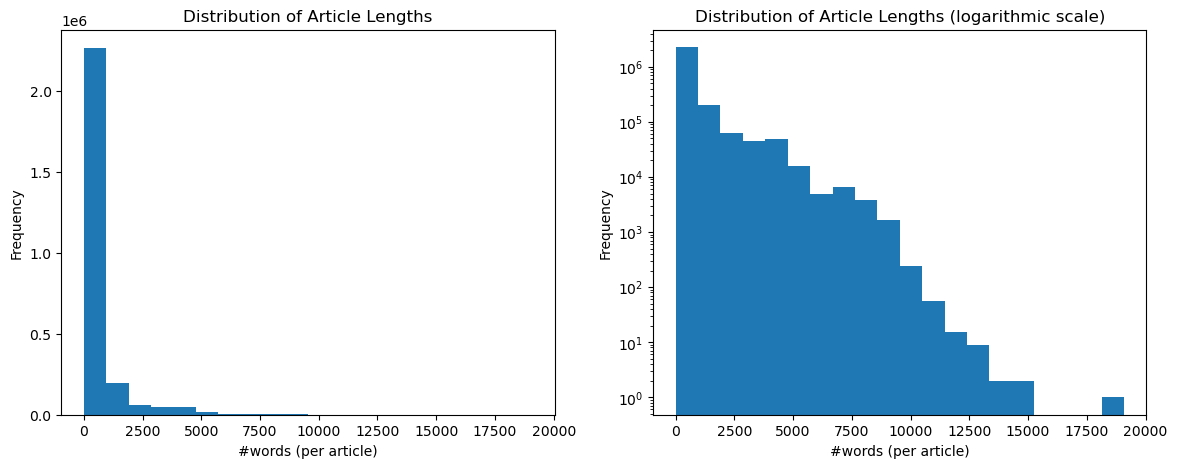

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_unique["size"].plot.hist(bins=20, ax=axes[0], 
                         title="Distribution of Article Lengths",
                         figsize=(14,5))
df_unique["size"].plot.hist(bins=20, ax=axes[1],
                         title="Distribution of Article Lengths (logarithmic scale)",
                         logy=True)
axes[0].set_xlabel("#words (per article)")
axes[1].set_xlabel("#words (per article)")
plt.show()

<AxesSubplot: title={'center': 'Distribution of Article Lengths, up to 2500 words'}, ylabel='Frequency'>

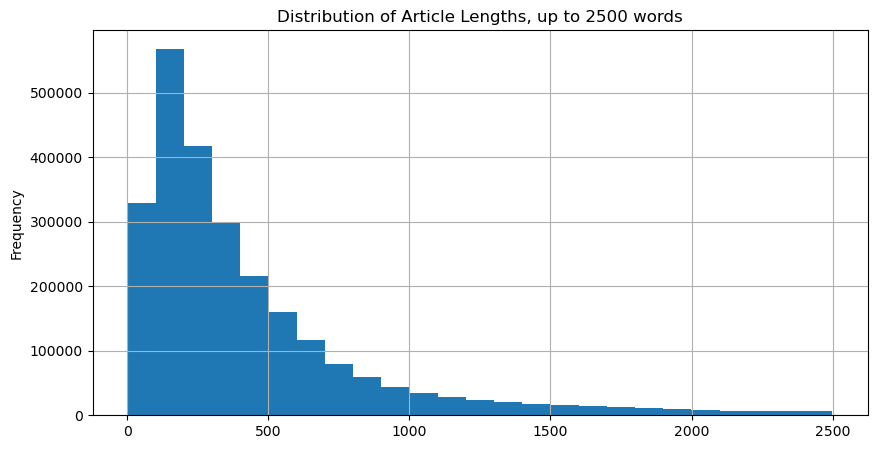

In [ ]:
size2500 = df_unique[df_unique["size"]<2500]
size2500["size"].plot.hist(bins=25, grid=True,
                         title="Distribution of Article Lengths, up to 2500 words",
                         figsize=(10,5))

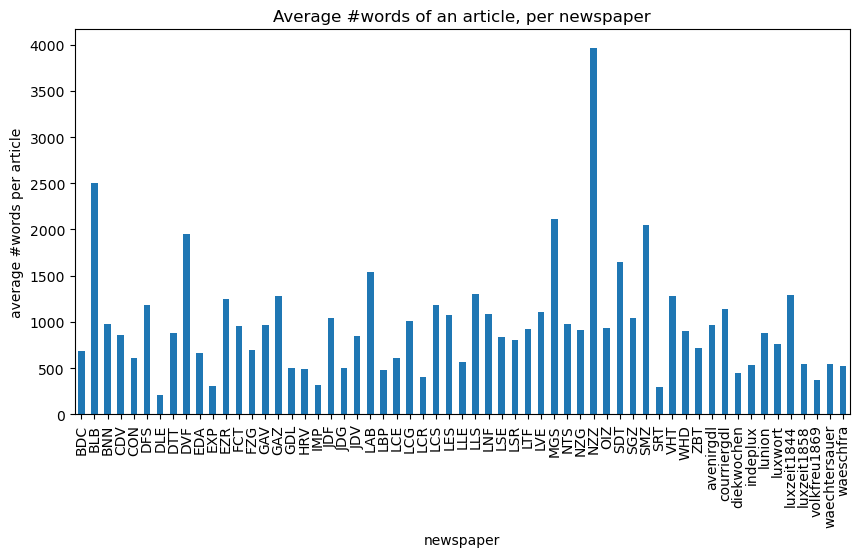

In [ ]:
df_unique.groupby("newspaper")["size"].mean().plot(kind="bar", ylabel="average #words per article", figsize=(10,5),
                        title="Average #words of an article, per newspaper")
plt.show()
# depends heavily on quality of OCR => e.g. NZZ displayed as whole page

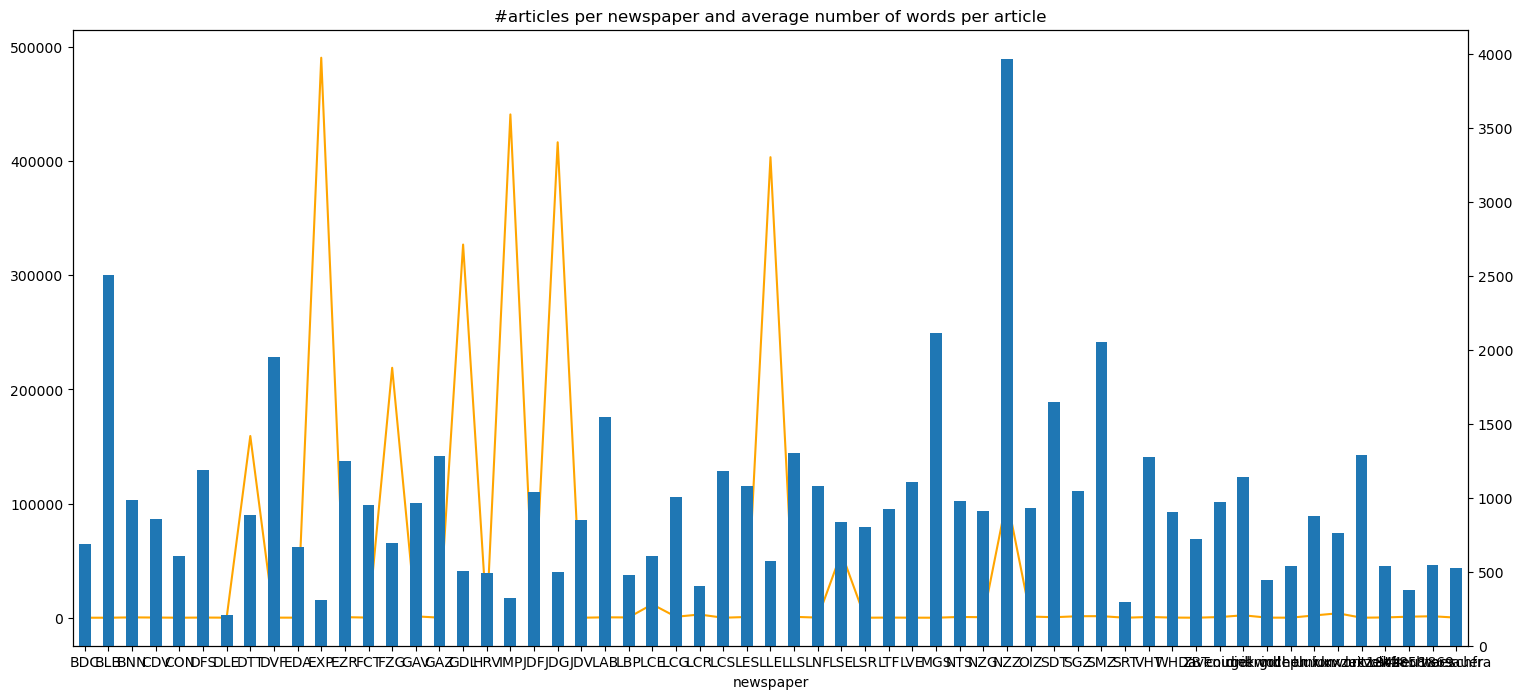

In [ ]:
#plot both into the same subplot
ax1 = df_unique.groupby("newspaper")["size"].mean().plot(kind="bar")
ax2 = ax1.twinx()
articles_per_newspaper["all"].plot.line(title="#articles per newspaper and average number of words per article", 
                                             figsize=(18, 8), color="orange", ax=ax2)

plt.show()

### Number of tokens per article
***from here on: sample of data***

In [ ]:
df_sample = df_unique.sample(n=50000, random_state=2023)

In [ ]:
df_sample["content"] = df_sample["content"].str.lower()

In [ ]:
def remove_stopwords(string_series, language):
    #get stopwords and put them in a regex pattern
    stop_words = stopwords.words(language)
    pat = r'\b(?:{})\b'.format('|'.join(stop_words))

    #replace stopwords and then double spaces
    no_stopwords = string_series.str.replace(pat, '', regex=True)
    no_stopwords = no_stopwords.str.replace(r'\s+', ' ', regex=True)
    return no_stopwords

def remove_punctuation(string_series):
    #punctuation: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    puncts = list(string.punctuation)
    #add some punctuation by hand
    puncts += ["•", "¦", "«", "»", "„", "£", "—"]
    pat = r'(?:{})'.format('|'.join(re.escape(s) for s in puncts))

    #replace punctuation and then double spaces
    no_punct = string_series.str.replace(pat, '', regex=True)
    no_punct = no_punct.str.replace(r'\s+', ' ', regex=True)
    return no_punct

def remove_stop_punct(string_series, language):
    return remove_punctuation(remove_stopwords(string_series, language))

def del_short_words(string_series):
    #delete all words with one or two characters, excluding ap, up and tt
    pat = r"(?!ap|up|tt)\b(..)\b"
    no_shortwords = string_series.str.replace(pat, '', regex=True)
    no_shortwords = no_shortwords.str.replace(r'\s+', ' ', regex=True)
    return no_shortwords

#check if regex matches correctly
#re_str = "This is a !regular OCRized string with ap and up an' tt in it"
#re.findall(r"(?!ap|up|tt)\b(..)\b", re_str)

In [ ]:
df_sample["tokens"] = ""

print("starting with german")
df_sample.loc[df_sample.language == "de", "tokens"] = remove_stop_punct(df_sample[df_sample.language == "de"]["content"], "german")

print("moving to french")
df_sample.loc[df_sample.language == "fr", "tokens"] = remove_stop_punct(df_sample[df_sample.language == "fr"]["content"], "french")

print("deleting words with 1 or 2 characters")
df_sample["tokens"] = del_short_words(df_sample["tokens"])
df_sample["tokens"] = df_sample["tokens"].str.split()

starting with german
moving to french
deleting words with 1 or 2 characters


In [ ]:
df_sample["size_tokens"] = df_sample["tokens"].str.len()

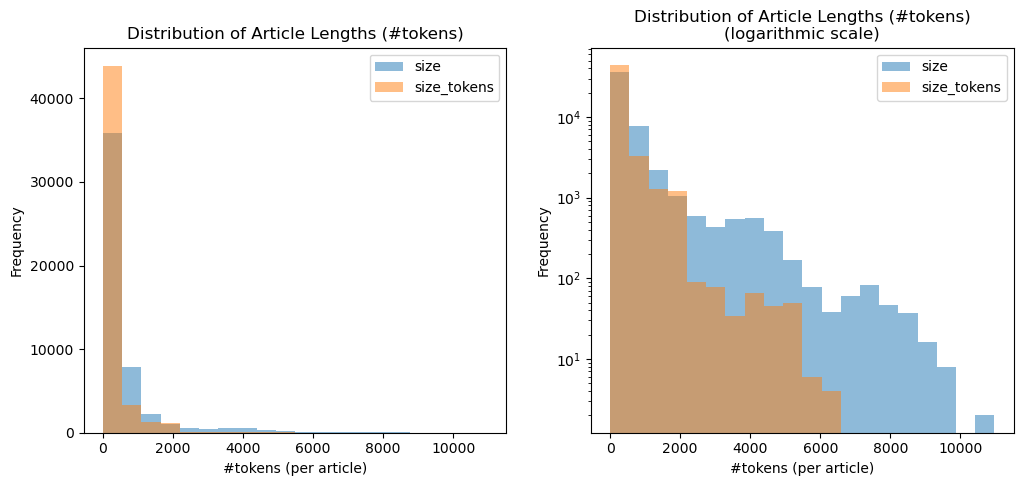

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
df_sample.plot.hist(column=["size", "size_tokens"], bins=20, alpha=0.5, ax=axes[0],
                         title="Distribution of Article Lengths (#tokens)")

df_sample.plot.hist(column=["size", "size_tokens"], bins=20, alpha=0.5, ax=axes[1],
                         title="Distribution of Article Lengths (#tokens)\n(logarithmic scale)",
                         logy=True)
axes[0].set_xlabel("#tokens (per article)")
axes[1].set_xlabel("#tokens (per article)")
plt.show()

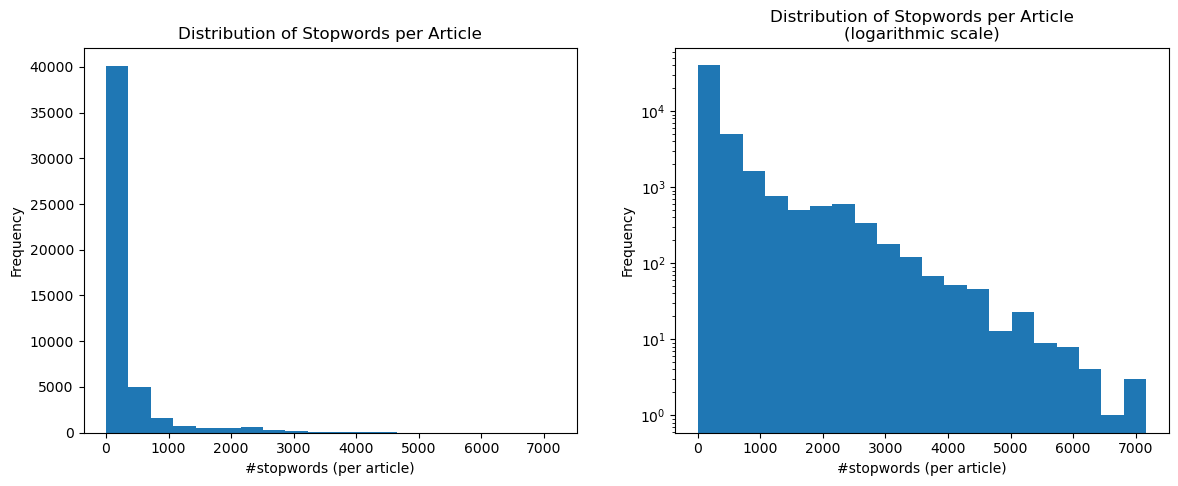

In [ ]:
df_sample["size_dif"] = df_sample["size"] - df_sample["size_tokens"]
fig, axes = plt.subplots(nrows=1, ncols=2)
df_sample["size_dif"].plot.hist(bins=20, ax=axes[0], 
                         title="Distribution of Stopwords per Article",
                         figsize=(14,5))
df_sample["size_dif"].plot.hist(bins=20, ax=axes[1],
                         title="Distribution of Stopwords per Article\n(logarithmic scale)",
                         logy=True)
axes[0].set_xlabel("#stopwords (per article)")
axes[1].set_xlabel("#stopwords (per article)")
plt.show()

In [ ]:
def sample_uids(df, col_name, comparison, limit, n_of_samples=5):
    if comparison == "smaller":
        selection = df[df[col_name] < limit]
    elif comparison == "equals":
        selection = df[df[col_name] == limit]
    else:
        selection = df[df[col_name] > limit]

    return list(selection.head(n_of_samples)["uid"])

In [ ]:
# IDs for Examples

#tokens
mean_tokens = round(df_sample["size_tokens"].mean())
print("IDs FOR EXAMPLES")
print(f"articles with low (<20) #tokens: {sample_uids(df_sample, 'size_tokens', 'smaller', 20)}\n\
articles with average ({mean_tokens}) #tokens: {sample_uids(df_sample, 'size_tokens', 'equals', mean_tokens)}\n\
articles with high #tokens: {sample_uids(df_sample, 'size_tokens', 'bigger', 4700)}\n\
")

#difference between words and tokens
mean_dif = round(df_sample["size_dif"].mean())
print(f"articles with low (<20) difference: {sample_uids(df_sample, 'size_dif', 'smaller', 20)}\n\
articles with average ({mean_dif}) difference: {sample_uids(df_sample, 'size_dif', 'equals', mean_dif)}\n\
articles with high difference: {sample_uids(df_sample, 'size_dif', 'bigger', 5200)}\n\
")


IDs FOR EXAMPLES
articles with low (<20) #tokens: ['JDG-1925-09-29-a-i0083', 'LLE-1928-07-09-a-i0056', 'DTT-1953-11-27-a-i0023', 'LLE-2003-06-18-a-i0350', 'LLE-1992-02-11-a-i0375']
articles with average (308) #tokens: ['JDG-1986-02-11-a-i0014', 'IMP-1958-05-27-a-i0203', 'IMP-2008-11-19-a-i0237', 'LLE-1930-01-10-a-i0034', 'JDG-1989-11-25-a-i0080']
articles with high #tokens: ['GDL-1985-05-14-a-i0146', 'JDG-1986-02-20-a-i0037', 'JDG-1995-07-12-a-i0054', 'GDL-1986-12-04-a-i0091', 'GDL-1990-10-06-a-i0056']

articles with low (<20) difference: ['JDG-1925-09-29-a-i0083', 'JDG-1997-10-31-a-i0029', 'LLE-1928-07-09-a-i0056', 'LSE-1953-04-16-a-i0064', 'DTT-1953-11-27-a-i0023']
articles with average (326) difference: ['IMP-1959-02-27-a-i0334', 'IMP-1956-11-09-a-i0081', 'GDL-1983-03-10-a-i0170', 'JDG-1978-03-30-a-i0041', 'GDL-1984-03-16-a-i0223']
articles with high difference: ['GDL-1979-11-05-a-i0082', 'NZZ-1890-11-16-a-i0003', 'NZZ-1907-02-06-b-i0003', 'NZZ-1926-01-01-b-i0004', 'JDG-1975-04-08-a

## Position of the citations

### list of agency searchwords

In [ ]:
searchwords_str = """
containing afp or afpj or afpl or fafp or iafp or agence france presse
containing anp or algemeen nederland; not containing nationale - tagged as article
containing ansa or agenzia nationale 
containing apa or austria press
containing ap or associated press or vassociated or associated or yassociated or lassociated or dassociated or ass. press or assoc. press 
containing ats or atsj or atsl or atsi or fatsï or fatsl or atsf or agence telegraphique suisse or schweizerische depeschenagentur or sda
containing belga or beiga
containing bta or agence bulgare AND bulgare or bulgarisch 
containing ctk or ceteka 
containing ddp or dapd or deutscher depeschendienst
containing nachrichtenbüro or nachrichtenbureau or richtenbüro or richtenbureau or dnb or ldnb or ldnv or dnib or idrb or d0lb or dnv0 or idnb or d0lv 
containing domei or domci 
containing dpa or deutsche presse agentur
containing europapreß or europapreh or europapretz or europaprefz or leuropapreß or eurovapreß or europapieß or eurovapreh or seuropapreß or leuropapreh or europapieh or europaprch or leuropapretz or euiopapreß or guropapreß 
containing extel or exlel 
containing havas or bavas or hayas or havae or ilavas or llavas or flavas or haivas or uavas or havais or havasj or huvas or tlavas or jlavas or fhavas or lavas or havat or havaa or tiavas or haoas or hawas or haveis or liavas or havasl or hivas or hauas or iiavas or llaoas or heivas or havai or havasi or lfavas or mavas or hava or havasagentur or havasmeldung or haoasagentur or havasnote  
containing interfax
containing afpreuters or afpreuter or atsafp or atsreuters or atsreuter or atsjafp or atsap or aplddp or aplafp or afplap or dpalafp or atsjreuter or atsfafp or ddplap or aplsda or aplddp or sdalafp or atsjréd or atsréd
containing pap AND polonais or polnisch 
containing reutersche or reuterfche or neutersche or reuterschen or reuter'sche or neuterschen or reuterfchen or reuterbureau or reutermeldung or reuterbüro or  reuters or reuterï or reutei or rcuter or rcutcr or reulers or reuteragentur or reutcr or reuterbüro or reutermeldung
containing spk or schweizerische politische korrespondenz or schweizer mittelpresse or smp 
containing stefani or steîani or stelani or stcfani or slefani or stefanl 
containing tanjug or tanyoug or tanjoug 
containing tass or tafz or telegraphen-agentur or itar
containing telunion or ltelunion or stelunion or telunwn or telegraphen union 
containing tt AND suedois or suedoise or schwedisch or schwedische 
containing upi or united press or united prefz 
containing wolff or lwolff or lwolsf or lwolss or iwolff or wofff or wolffsbüro or wolffbüro or wolffbüros or wolffbureau or wolffbureaus or wolff'sche or wolffmeldung]
"""

searchwords = [word.strip() for word in re.split("\ncontaining|\sor\s", searchwords_str)]
#first entry is emmpty string
searchwords = searchwords[1:]
searchwords.remove("bulgarisch")
searchwords.remove("schwedisch")
searchwords.remove("schwedische")
searchwords.remove("suedoise")


entries_to_replace = {
    'algemeen nederland; not containing nationale - tagged as article': "algemeen nederland",
    'agence bulgare AND bulgare': "agence bulgare",
    'pap AND polonais': "pap",
    'tt AND suedois': "tt",
    'wolffmeldung]': "wolffmeldung"
}

for wrong, correct in entries_to_replace.items():
    searchwords.remove(wrong)
    searchwords.append(correct)

#searchwords 

### position of agency mention

In [ ]:
def is_in_outer_area(content_list, searchwords, position):
    if position == "start":
        intersect = set(content_list[:5]).intersection(set(searchwords))
    elif position == "end":
        intersect = set(content_list[-5:]).intersection(set(searchwords))
    
    return len(intersect) > 0

In [ ]:
is_in_start = df_sample.apply(lambda row: is_in_outer_area(row["tokens"], searchwords, "start"), axis=1).sum()
is_in_end = df_sample.apply(lambda row: is_in_outer_area(row["tokens"], searchwords, "end"), axis=1).sum()
print(f"% of articles (roughly) starting with agency mention: {round(is_in_start/len(df_sample)*100)}%\n\
% of articles (roughly) ending with agency mention: {round(is_in_end/len(df_sample)*100)}%")

% of articles (roughly) starting with agency mention: 7%
% of articles (roughly) ending with agency mention: 31%


### brackets e.g. (AFP)

In [ ]:
#pattern to match the agency names with at least one bracket around it
pat = r'\(*\s*(?:{})\s*\)'.format('|'.join(searchwords))+ '|' + r'\(\s*(?:{})\s*\)*'.format('|'.join(searchwords))

#test
#text = "This is a string with (afp), ( ddp) and (havasl and iafp) in it"
#print(re.findall(pat, text)) 

df_sample["na_with_brackets"] = df_sample["content"].str.contains(pat, regex=True)
print(f"% of articles containing news agency mention with brackets: {round(df_sample['na_with_brackets'].sum()/len(df_sample)*100)}%")

% of articles containing news agency mention with brackets: 59%


## Multiple agencies: #of words between two mentions

In [ ]:
na_mixed_sample = df_sample[df_sample["newsagency_list"].str.len() > 1]

def min_dist_between_nas(text, searchwords=searchwords):
    pat = r'\b(?:{})\b'.format('|'.join(searchwords))
    positions = [(m.start(), m.end()) for m in re.finditer(pat, text)]
    try:
        start, end = list(map(list, zip(*positions)))
        start = np.array(start[1:])
        end = np.array(end[:-1])
        return np.min(start-end)
    except:
        return None


In [ ]:
min_dists = na_mixed_sample["content"].apply(min_dist_between_nas)
print(f"minimal distance of 1 character between news agency mentions in one article: {round((min_dists<2).sum()/len(na_mixed_sample)*100)}% of the cases")
print(f"minimal distance of <=2 characters between news agency mentions in one article: {round((min_dists<3).sum()/len(na_mixed_sample)*100)}% of the cases")
print(f"minimal distance of <=3 characters between news agency mentions in one article: {round((min_dists<4).sum()/len(na_mixed_sample)*100)}% of the cases")

minimal distance of 1 character between news agency mentions in one article: 16% of the cases
minimal distance of <=2 characters between news agency mentions in one article: 22% of the cases
minimal distance of <=3 characters between news agency mentions in one article: 37% of the cases


## Containing "agence" or "agentur"

In [ ]:
sum_agentur = df_sample["content"].str.contains("agence|agentur", regex=True).sum()
print(f"% of articles containing 'agence' or 'agentur': {round(sum_agentur/len(df_sample)*100)}%")

% of articles containing 'agence' or 'agentur': 10%
